In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [157]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [158]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [159]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total'].to_frame()

    upsampled = y_data.resample('MS')
    y_data = upsampled.interpolate(method='spline', order=2)

    return y_data


### Combine Y and X data

In [160]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")

start_date_analysis = "2000-08-01"  # make divisible by 12 to make coding easier
save_some_data_for_predictions = "2024-07-01"
df1 = regressionData.loc[start_date_analysis:save_some_data_for_predictions,:].copy()

df1.columns

Index(['gdp_total_deseasonalized', '^AEX', 'ASML.AS', 'AIR', 'ING', 'WKL.AS',
       'STLA', 'AD.AS', 'PHG', '^FVX',
       ...
       'Italy_unemply_F', 'Italy_unemply_M', 'Spain_unemply_F',
       'Spain_unemply_M', 'Belgium_unemply_F', 'Belgium_unemply_M',
       'Japan_unemply_F', 'Japan_unemply_M', 'United States_unemply_F',
       'United States_unemply_M'],
      dtype='object', length=143)

### Save transformations of GDP

In [161]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()


In [162]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          '^FVX',
          '^TNX',
          '^TYX',
          '^VIX',

          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'MaandmutatieCPI_3',
          'ProducerConfidence_1', 
          'ExpectedActivity_2',

          'Crude oil, Brent',
          'Coal, Australian',
          'Natural gas, Europe', 
          'Natural gas index',

          'Gold', 
          'Platinum',
          'M3_1', 
          # 'M3_2',
          # 'M1',

          'BE_Inflation',
          'EE_Inflation',
          'NL_Inflation',

          
          'CCICP_NLD_CLI', 
          'BCICP_NLD_CLI',
          'BCICP_DEU',

          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
           
          'United States_unemply_F',
          'United States_unemply_M', 
          
        ]]


### Drop if number of observations less than GDP

In [163]:

def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)
df1

[]


,gdp_total,^AEX,^FVX,^TNX,^TYX,^VIX,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,...,BE_Inflation,EE_Inflation,NL_Inflation,CCICP_NLD_CLI,BCICP_NLD_CLI,BCICP_DEU,Netherlands_unemply_F,Netherlands_unemply_M,United States_unemply_F,United States_unemply_M
2000-08-01,166653.477407,686.172175,6.050304,5.820391,5.710565,18.088696,452.0,31.0,33.0,30.0,...,3.5,4.4,2.5,102.09570,101.5040,100.98630,4.9,2.5,4.3,3.9
2000-09-01,167299.152264,674.714762,5.914000,5.788050,5.819200,19.687500,354.0,30.0,30.0,30.0,...,4.0,4.7,2.9,102.13650,101.4734,100.99670,4.8,2.5,4.0,3.9
2000-10-01,167805.000000,659.090454,5.766818,5.735000,5.801091,25.200000,440.0,32.0,32.0,31.0,...,3.7,5.4,3.2,102.20640,101.4700,100.98880,4.8,2.4,3.9,3.9
2000-11-01,168175.711673,672.587724,5.687381,5.702333,5.767952,26.382857,495.0,30.0,29.0,30.0,...,3.7,5.7,2.9,102.13510,101.4057,100.92470,4.7,2.4,4.0,3.9
2000-12-01,168405.657073,644.169993,5.156150,5.228450,5.486500,26.530500,360.0,31.0,29.0,32.0,...,3.0,5.0,2.9,101.92100,101.2714,100.80090,4.6,2.3,3.8,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234863.025267,863.843002,4.201850,4.208100,4.362250,13.787500,345.0,-22.0,-35.0,-14.0,...,3.8,4.1,3.1,99.40694,100.0772,98.83055,3.8,3.5,3.9,3.7
2024-04-01,235834.000000,877.564285,4.558182,4.538318,4.656955,16.137727,427.0,-21.0,-34.0,-13.0,...,4.9,3.1,2.6,99.38541,100.1734,98.79703,3.8,3.6,3.8,3.9
2024-05-01,236624.203208,906.555914,4.499955,4.481955,4.618364,13.090455,343.0,-22.0,-38.0,-12.0,...,4.9,3.1,2.7,99.36152,100.2592,98.79351,3.7,3.5,3.7,4.2
2024-06-01,237287.255097,922.693997,4.318842,4.305105,4.445632,12.676842,377.0,-23.0,-38.0,-14.0,...,5.4,2.8,3.4,99.37430,100.2941,98.75754,3.8,3.5,4.0,4.1


### Add 'sure' data and random data

In [164]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

# trend
df1['trend'] = [i for i in range(0, len(df1))]

### Standard Scaler

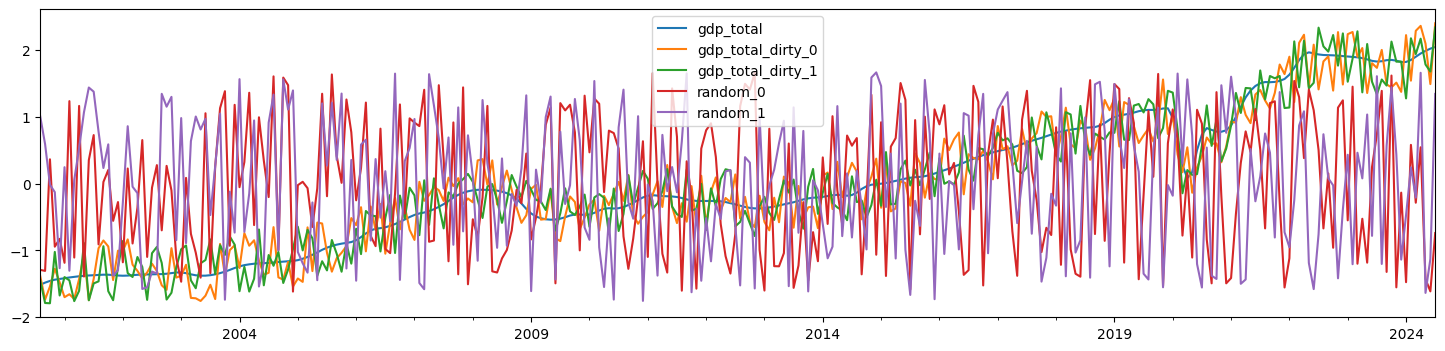

In [165]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [166]:
# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   

In [167]:
def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

In [168]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [169]:
def seasonality_test(data):
    kw_test1 = data.loc[start_date_analysis:save_some_data_for_predictions,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [170]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)

In [171]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [172]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
# Causing loss of data!!!
#scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    print(i)
    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

MaandmutatieCPI_3
random_0
random_1


[ 0  2  4  7  9 12 14 17 20 21 22 23 24 25 26 27 29 32 33 34 35 36 37 38
 39]
['^AEX', '^TNX', '^VIX', 'EconomischKlimaat_2', 'EconomischeSituatieLaatste12Maanden_4', 'FinancieleSituatieKomende12Maanden_7', 'CPI_1', 'ExpectedActivity_2', 'Natural gas, Europe', 'Natural gas index', 'Gold', 'Platinum', 'M3_1', 'BE_Inflation', 'EE_Inflation', 'NL_Inflation', 'BCICP_NLD_CLI', 'Netherlands_unemply_M', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


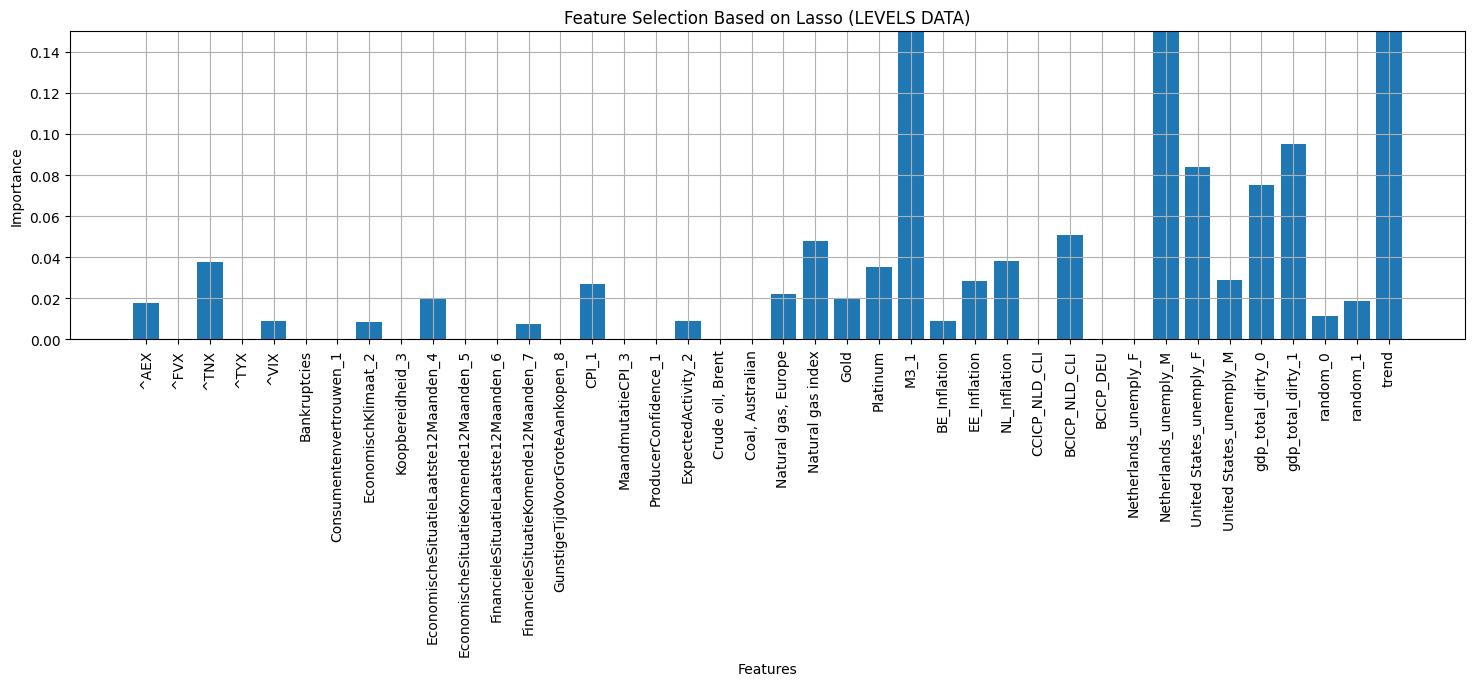

(288, 41)


In [173]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.001, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  3  4  5  9 10 11 13 14 15 16 17 19 20 21 23 25 26 27 29 30 32 33 35
 36 37 38 39]
['^AEX', '^TYX', '^VIX', 'Bankruptcies', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'MaandmutatieCPI_3', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Coal, Australian', 'Natural gas, Europe', 'Natural gas index', 'Platinum', 'BE_Inflation', 'EE_Inflation', 'NL_Inflation', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_M', 'United States_unemply_F', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


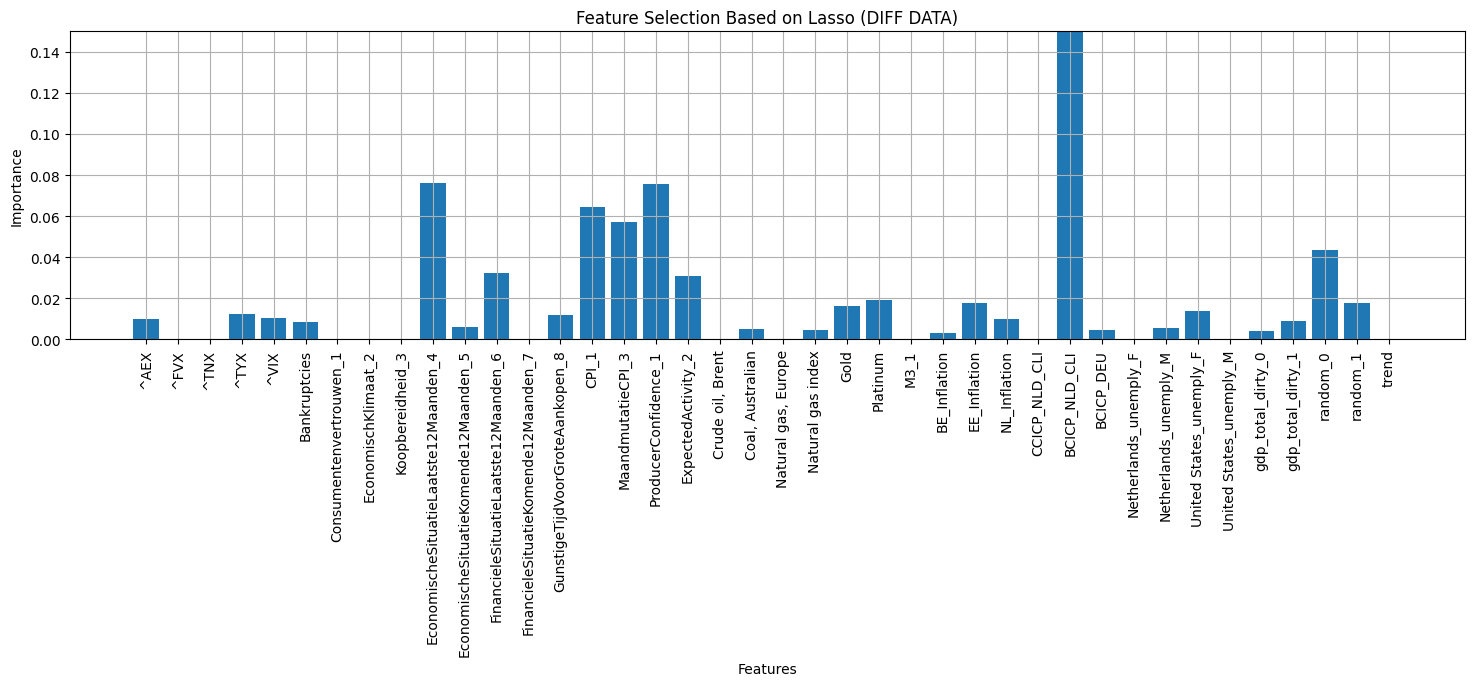

In [174]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [175]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])

[ 0  2  4  5  6  9 10 11 12 13 14 16 17 18 19 20 21 22 23 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40]
['gdp_total_lag_1', '^FVX_lag_1', '^TYX_lag_1', '^VIX_lag_1', 'Bankruptcies_lag_1', 'Koopbereidheid_3_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'MaandmutatieCPI_3_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'Natural gas, Europe_lag_1', 'Natural gas index_lag_1', 'Gold_lag_1', 'M3_1_lag_1', 'BE_Inflation_lag_1', 'EE_Inflation_lag_1', 'NL_Inflation_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'ra

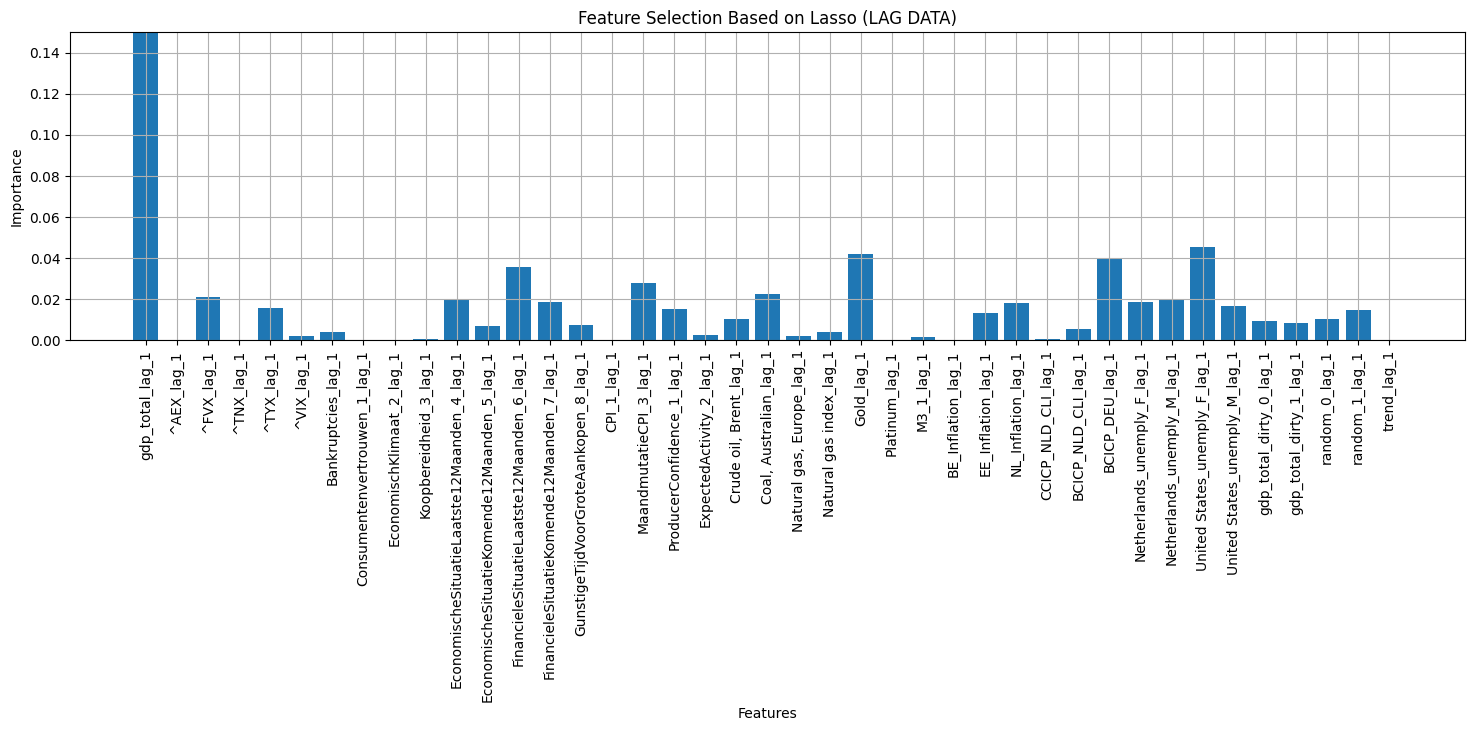

In [176]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  4  5  6 10 11 12 13 14 17 18 19 20 22 24 25 27 28 30 31 33 34 36 37]
['gdp_total_lag_1', '^TYX_lag_1', '^VIX_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'Natural gas index_lag_1', 'Platinum_lag_1', 'M3_1_lag_1', 'EE_Inflation_lag_1', 'NL_Inflation_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1']


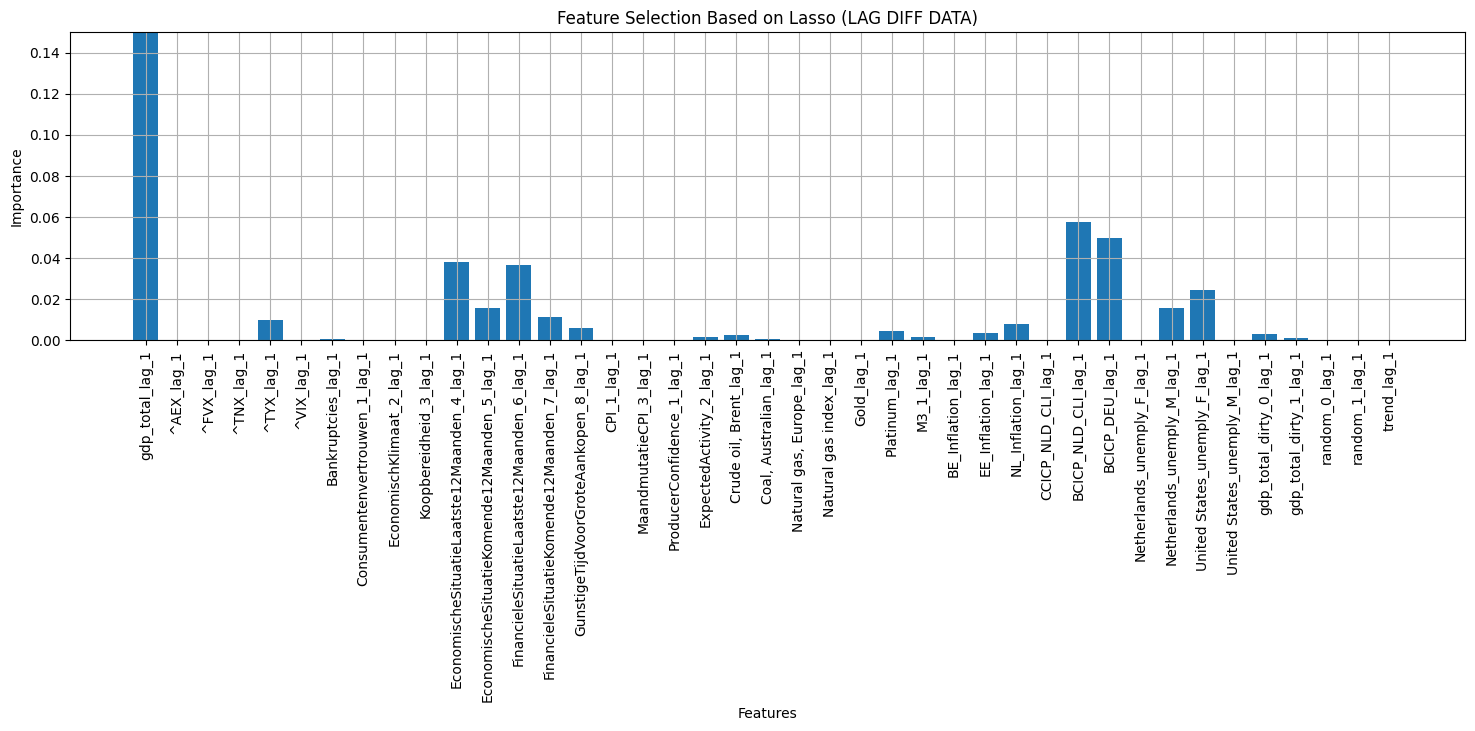

In [177]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [178]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(41, 3)


### If not stationary, difference, then test for stationarity again

In [179]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]


In [180]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
^FVX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TNX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TYX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^VIX,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality


<Axes: >

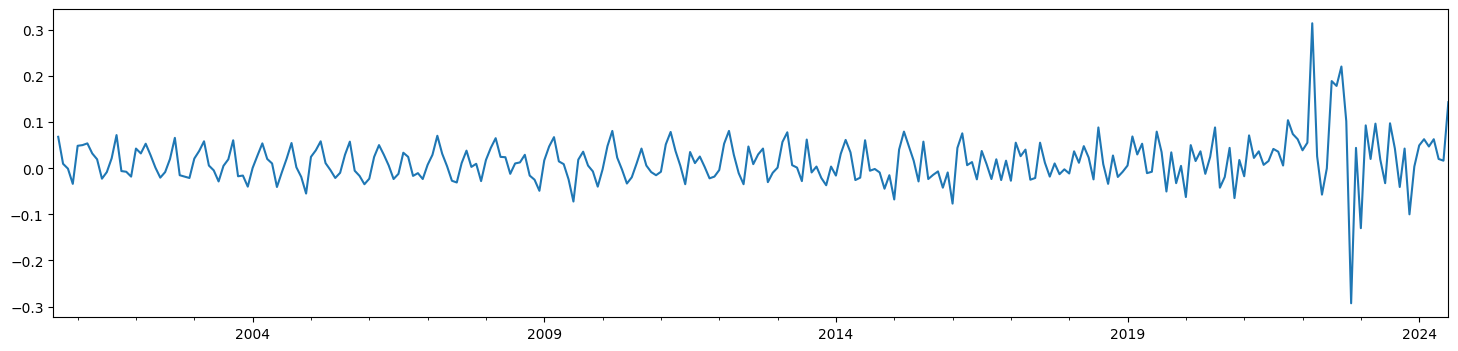

In [181]:
scaled_features_df_diff['CPI_1'].plot()

[ 0  3  4  9 11 13 17 18 26 28 30 33 34 35 36]
['^AEX', '^TYX', '^VIX', 'EconomischeSituatieLaatste12Maanden_4', 'FinancieleSituatieLaatste12Maanden_6', 'GunstigeTijdVoorGroteAankopen_8', 'ExpectedActivity_2', 'Crude oil, Brent', 'EE_Inflation', 'CCICP_NLD_CLI', 'BCICP_DEU', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


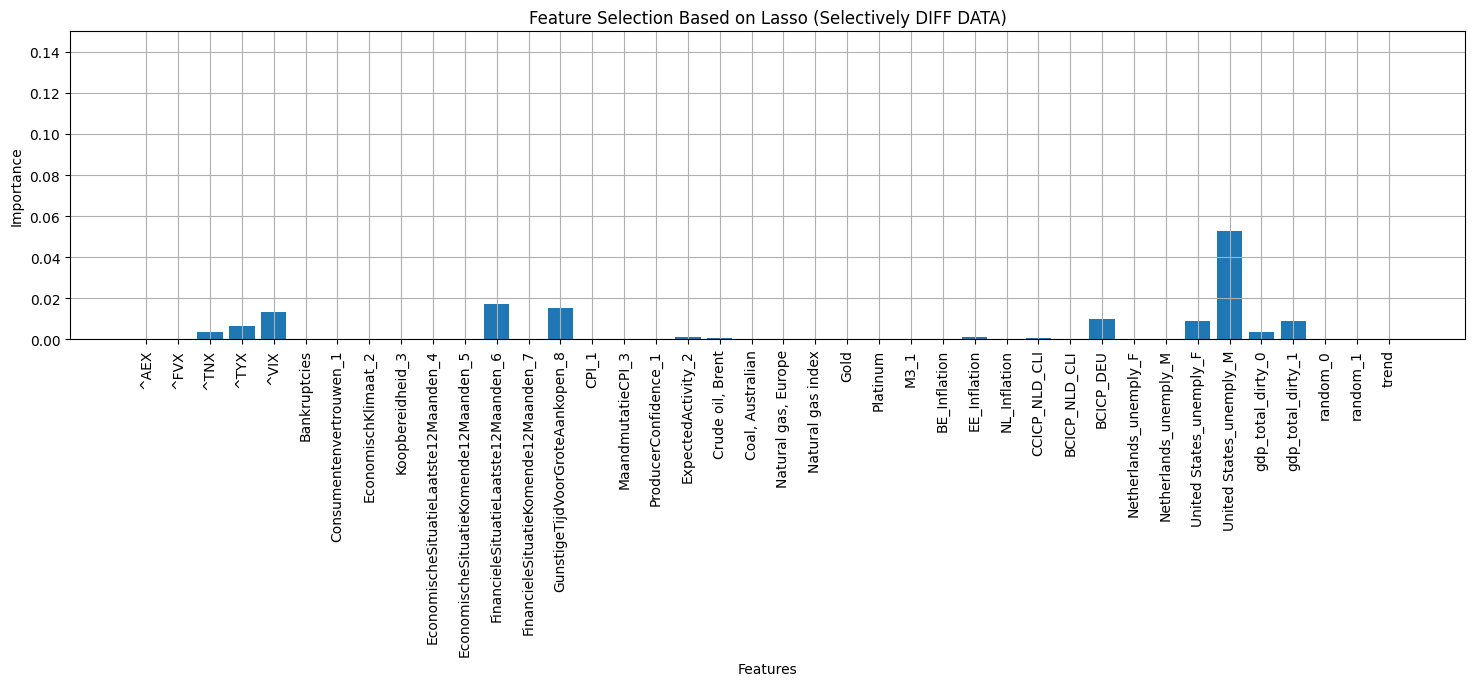

['^AEX',
 '^TYX',
 '^VIX',
 'EconomischeSituatieLaatste12Maanden_4',
 'FinancieleSituatieLaatste12Maanden_6',
 'GunstigeTijdVoorGroteAankopen_8',
 'ExpectedActivity_2',
 'Crude oil, Brent',
 'EE_Inflation',
 'CCICP_NLD_CLI',
 'BCICP_DEU',
 'United States_unemply_F',
 'United States_unemply_M',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1']

In [182]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

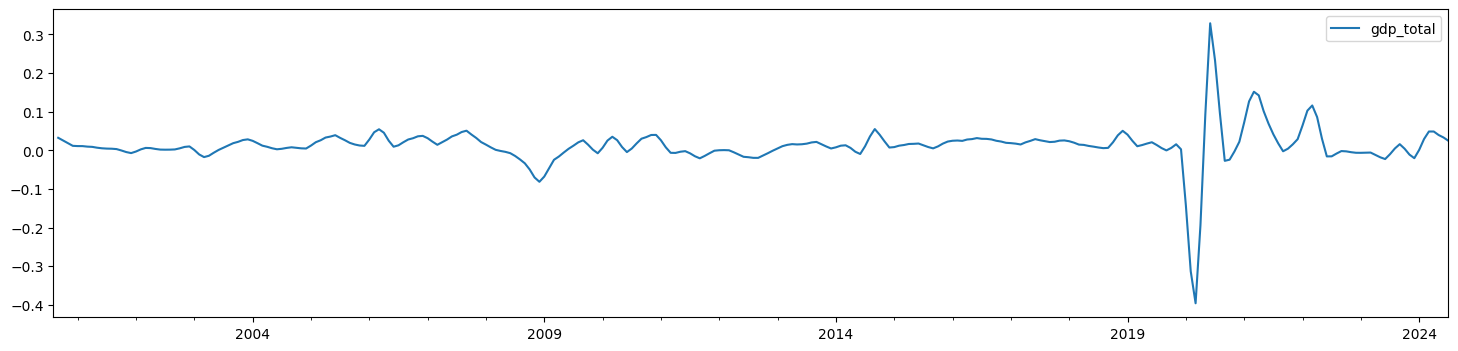

In [183]:
scaled_features_df_diff[['gdp_total']].plot()

In [184]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(288, 82)


In [185]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

In [186]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(288, 38)


[ 0  5 10 12 14 18 27 29 31 34]
['gdp_total_lag_1', '^VIX_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ExpectedActivity_2_lag_1', 'EE_Inflation_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'United States_unemply_F_lag_1']


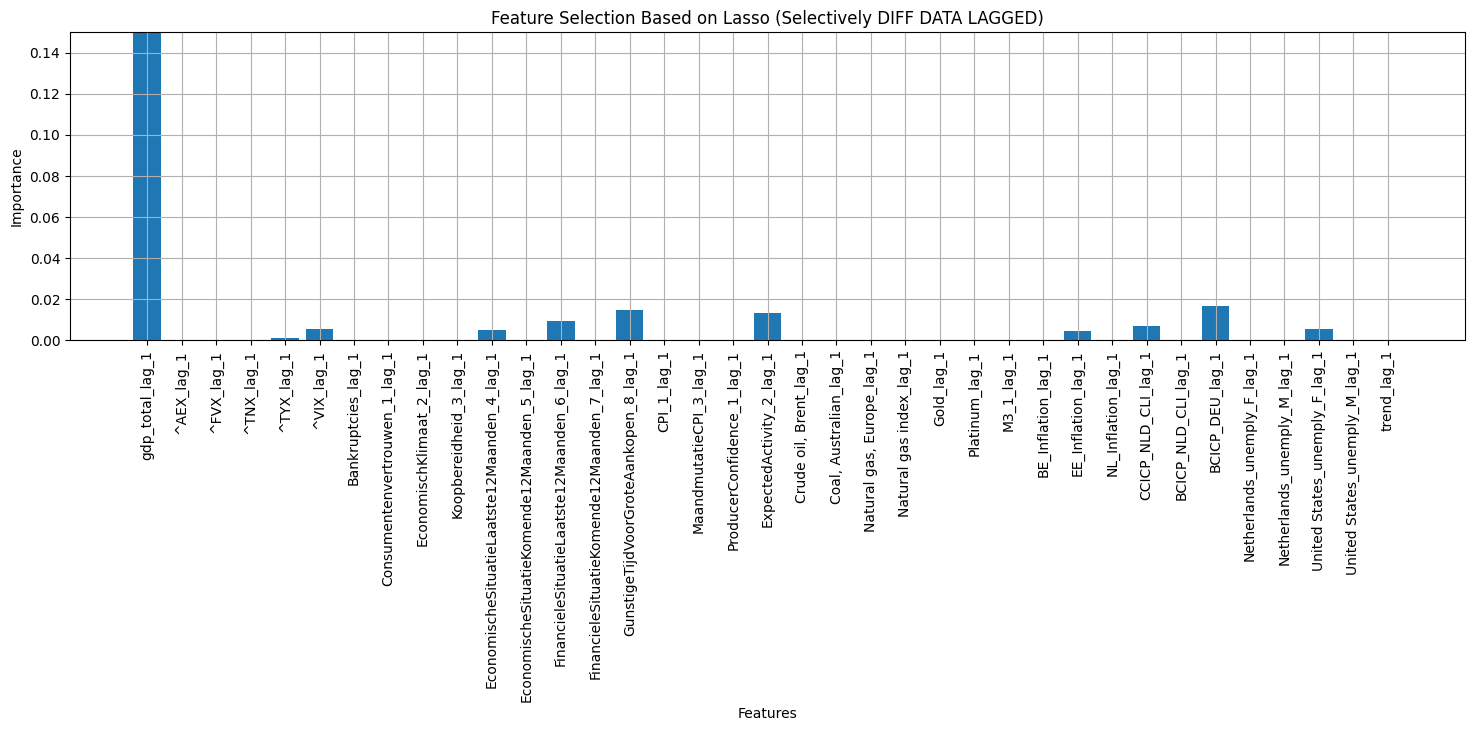

In [187]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,gdp_total_lag_1,^VIX_lag_1,EconomischeSituatieLaatste12Maanden_4_lag_1,FinancieleSituatieLaatste12Maanden_6_lag_1,GunstigeTijdVoorGroteAankopen_8_lag_1,ExpectedActivity_2_lag_1,EE_Inflation_lag_1,CCICP_NLD_CLI_lag_1,BCICP_DEU_lag_1,United States_unemply_F_lag_1
2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,0.032321,NaN,-0.211583,NaN,2.536427,2.048143,0.811614,0.026189,1.810480,0.385354,-0.686464
2000-10-01,0.025322,0.032321,-0.016320,-0.069314,2.536427,2.095155,-0.131350,0.092543,1.844242,0.392608,-0.849539
2000-11-01,0.018557,0.025322,0.656926,0.023105,2.600573,2.142168,0.738137,0.247370,1.902085,0.387098,-0.903898
2000-12-01,0.011511,0.018557,0.801390,-0.069314,2.536427,2.095155,0.272778,0.313725,1.843084,0.342386,-0.849539
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.048623,0.029118,-0.717779,0.069314,-0.350128,-1.101691,-0.204828,0.026189,-0.472613,-1.095695,-0.903898
2024-04-01,0.048605,0.048623,-0.736892,0.323465,-0.093546,-0.913641,-0.339537,-0.040166,-0.414473,-1.118344,-0.903898
2024-05-01,0.039556,0.048605,-0.449857,0.046209,0.034746,-0.913641,-0.119104,-0.261348,-0.432289,-1.141725,-0.958256
2024-06-01,0.033191,0.039556,-0.822023,-0.069314,0.163037,-0.772604,0.113576,-0.261348,-0.452058,-1.144180,-1.012614


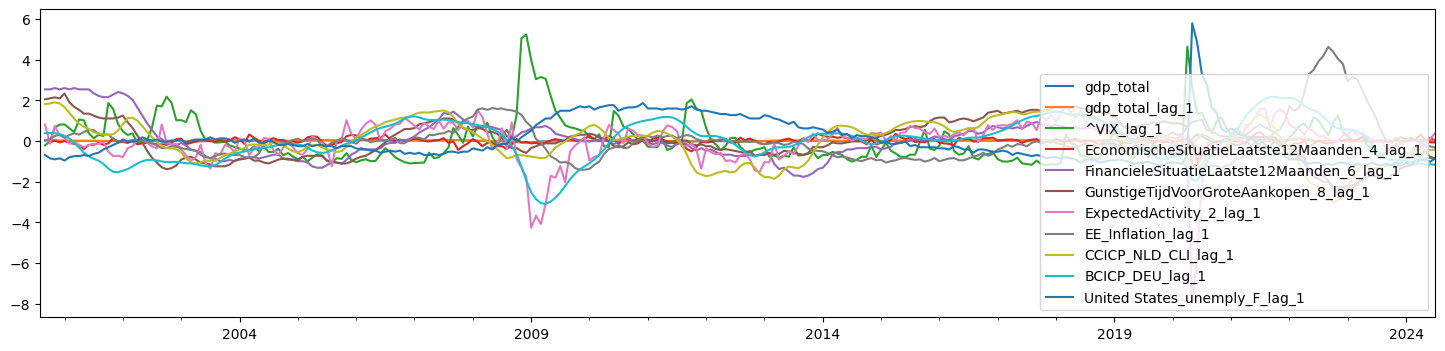

In [188]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

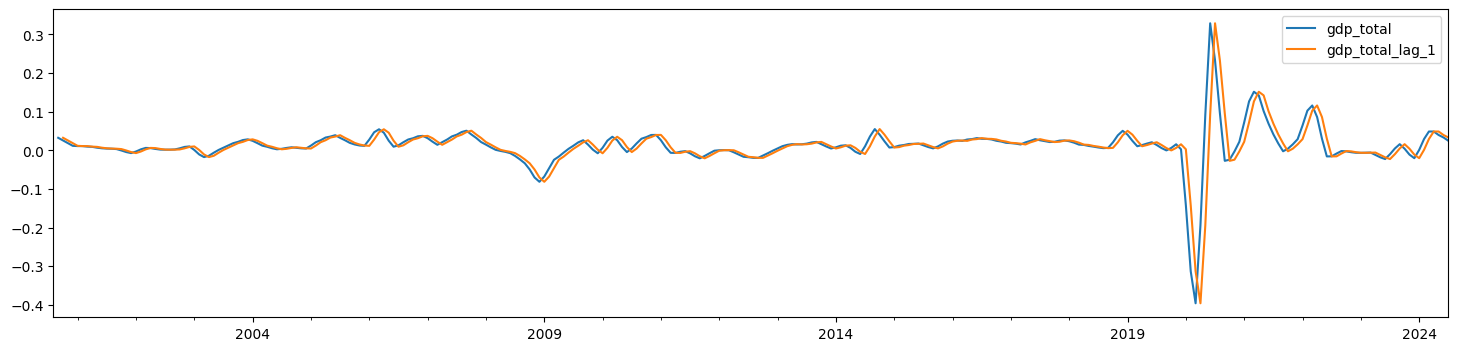

In [189]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [190]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2023-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     71.15
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.88e-68
Time:                        14:53:31   Log-Likelihood:                 601.33
No. Observations:                 270   AIC:                            -1181.
Df Residuals:                     259   BIC:                            -1141.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

<Axes: >

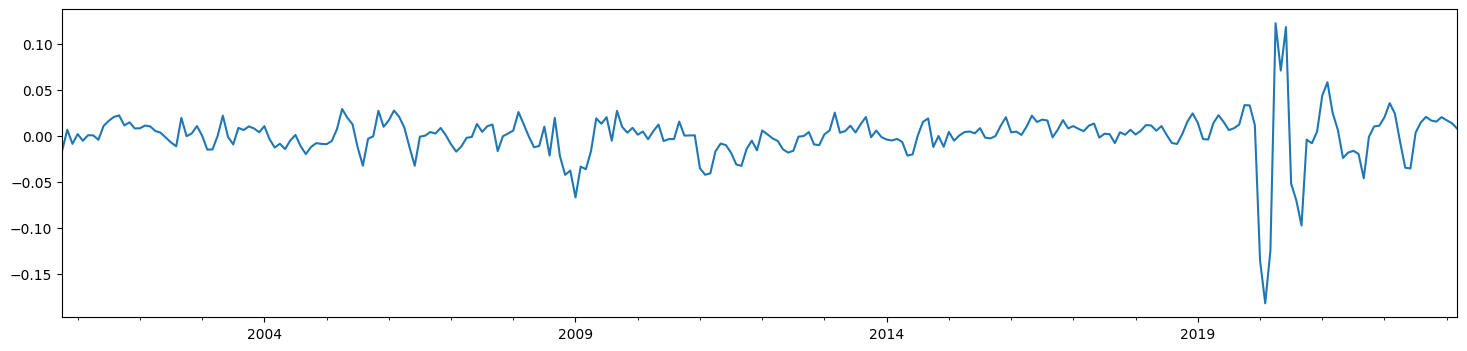

In [191]:
results.resid.plot()

<Axes: >

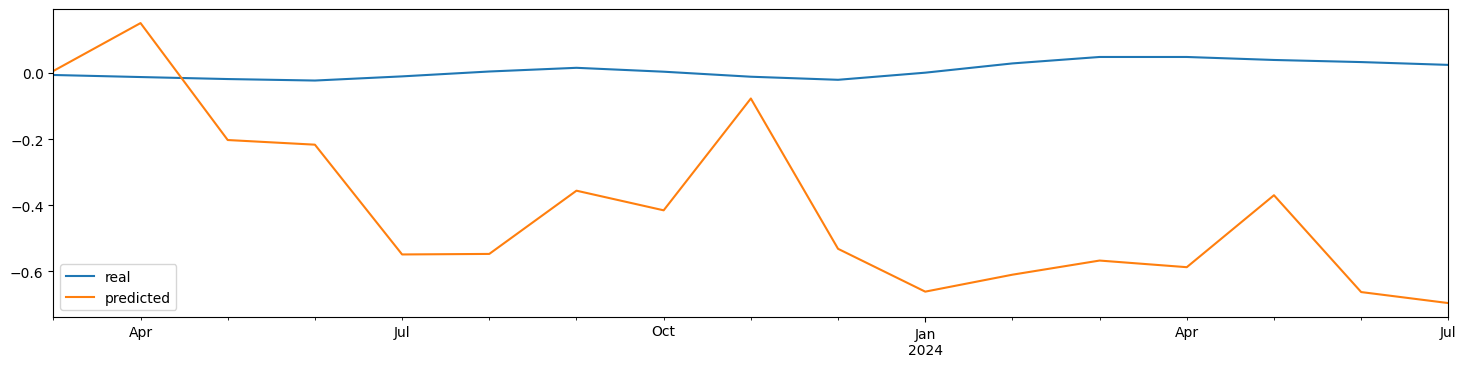

In [192]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Heteroskedasticity (Breusch-Pagan)


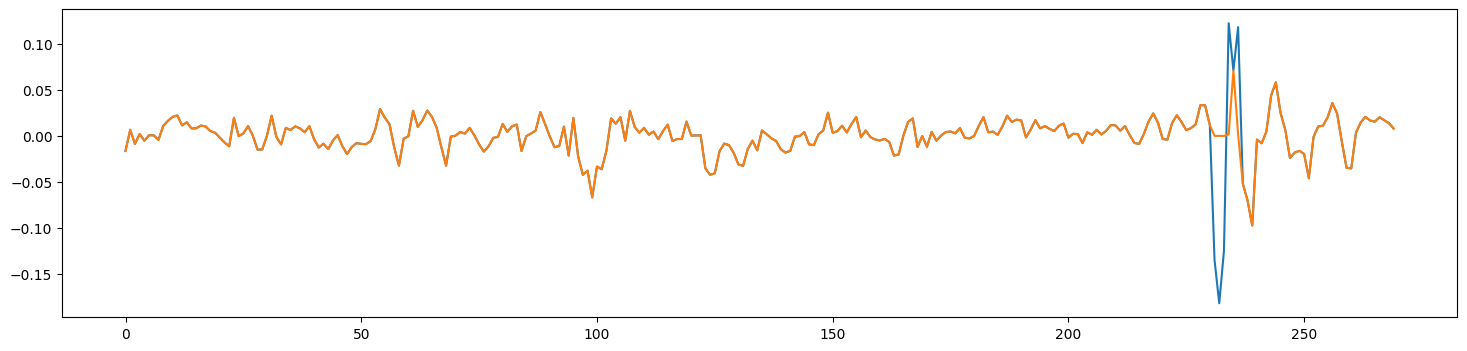

In [193]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [194]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [195]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.8234482324140677
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


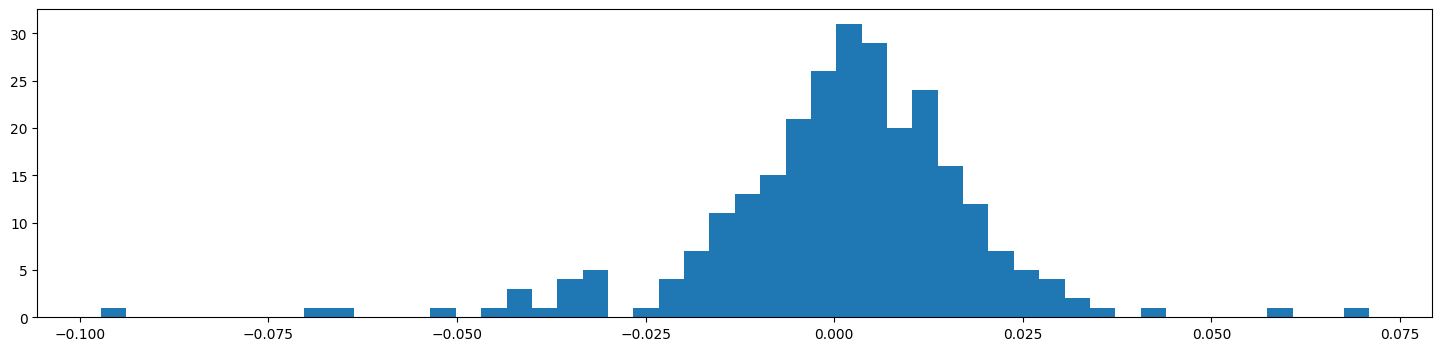

In [196]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [197]:

def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) + relativedelta(months=1)

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)



<Axes: >

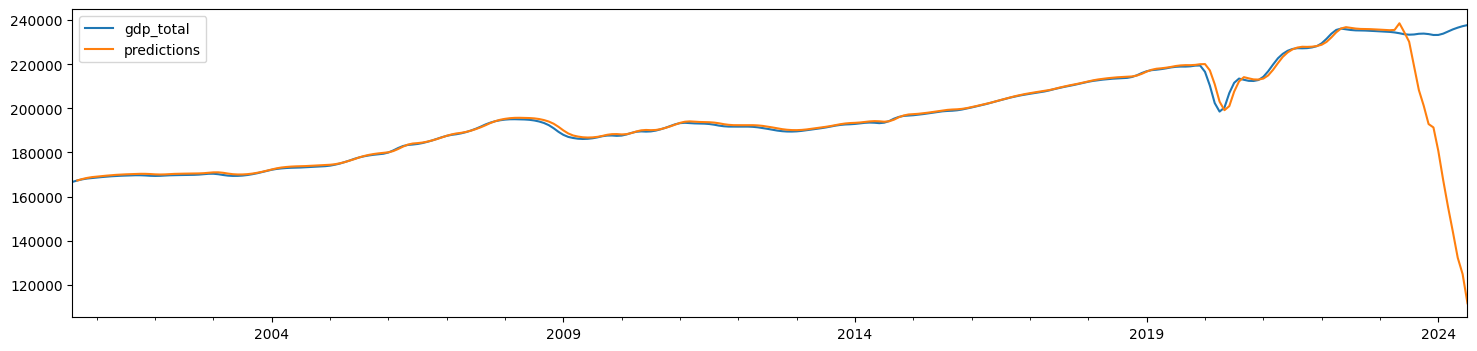

In [198]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()